---
title: NDSI based snow mapping with Sentinel-2
subtitle: Demonstrate how to map snow coverage using the Sentinel-2 data in EOPF Zarr format
authors:
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Valentina Premier
    orcid: 0000-0002-4629-2235
    github: vpremier
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-06-12
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords: ["data access", "xarray", "EOPF Zarr products"]
tags: ["sentinel-2", "xarray", "xarray-eopf", "xcube-eopf", "stac", "xcube"]
releaseDate: 2025-07-15
datePublished: 2025-07-15
dateModified: 2025-07-15
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents

1. [Introduction](#Introduction_SNOW)
2. [Import modules](#Import_SNOW)
3. [False Color Composite Visualization](#False_Color_SNOW)
4. [Cloud Masking](#CLOUD_SNOW) 
5. [NDSI Computation](#NDSI_SNOW)
6. [Snow Map Visualization](#Snow_Map_SNOW)

(Introduction_SNOW)=
## Introduction

**Snow monitoring plays a crucial role in water resource management** 💧. The increasing availability of remote sensing data 🛰️ offers significant advantages, but also introduces challenges related to data accessibility, processing, and storage. For operational use, scalable workflows are essential to ensure global applicability. Leveraging a cloud-native format like EOPF Zarr enables to get a quick prototype ready before scaling it up in the cloud, for instance using the openEO API. The workflow is built using the EOPF Zarr Samples STAC API, in combination with the xcube-eopf plugin, which enables us to build data cubes directly from STAC.  
If you want to know more detila about the usage of the xcube-eopf plugin, please refer to the [Introduction to xcube-eopf Data Store notebook](https://eopf-sample-service.github.io/eopf-sample-notebooks/introduction-xcube-eopf-plugin).

:::{hint} Overview
**Questions**
- What is a false color composite and what can be used for?
- What is the most easy way to build the datacube required for the analysis?
- How do I distinguish snow from other land covers using Sentinel-2 data?
- What features does the xcube-eopf backend provide?

**Objectives**
- Learn how to open and work with EOPF Sentinel-2 Zarr samples as analysis-ready datacubes (ARDC).
- Create you own snow map and compare it with the Scene Classification Layer (SCL) provided with the Sentinel-2 L2A product.
:::

(Import_SNOW)=
## Import Modules

The `xcube-eopf` data store is implemented as a plugin for `xcube`. Once installed, it registers the store ID `eopf-zarr` automatically and a new data store instance can be initiated via xcube's `new_data_store()` method.

In [1]:
from xcube.core.store import new_data_store
from xcube_eopf.utils import reproject_bbox

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import numpy as np

In [2]:
store = new_data_store("eopf-zarr")

(Data_Access_SNOW)=
## Data Access

We firstly define the parameters that will be used to query the [EOPF Sentinel Zarr Samples STAC API](https://stac.browser.user.eopf.eodc.eu/?.language=en).  
The Area Of Interest (AOI) covers part of the [Oetztal Alps](https://en.wikipedia.org/wiki/%C3%96tztal_Alps), between South Tyrol (Italy) and Tyrol (Austria).  
We will work on a single image, which is almost cloud-free, but you could easily extend the example to multiple dates.

In [3]:
bbox = [10.6, 46.74, 11, 46.91]
crs_utm = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)

Pass the parameters to the `xcube` plugin and create the datacube.  

💡 **Note**  
`open_data()` builds a Dask graph and returns a lazy `xarray.Dataset`. No actual data is loaded at this point. The data is loaded as reflectances, i.e. with the offset and scale factors already applied.

In [4]:
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-06-18", "2025-06-20"],
    spatial_res=10,
    crs=crs_utm,
    variables=["b02", "b03", "b04", "b08", "b11", "scl"],
)
ds

<xarray.Dataset> Size: 249MB
Dimensions:      (time: 1, y: 1960, x: 3095)
Coordinates:
  * time         (time) datetime64[ns] 8B 2025-06-19T10:15:59.024000
    spatial_ref  int64 8B ...
  * x            (x) float64 25kB 6.218e+05 6.219e+05 ... 6.528e+05 6.528e+05
  * y            (y) float64 16kB 5.197e+06 5.197e+06 ... 5.178e+06 5.178e+06
Data variables:
    b02          (time, y, x) float64 49MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, y, x) float64 49MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, y, x) float64 49MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08          (time, y, x) float64 49MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b11          (time, y, x) float64 49MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 6MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

(False_Color_SNOW)=
## False Color Composite Visualization

Let's **visualize a false color composite** (R: SWIR, G: NIR, B: RED) and the classic RGB side by side.  
In this case, you can notice that false color composite enhances the visibility of snow-covered areas compared to clouds.  
Before the visualization, we rescale the data to improve the visibility.

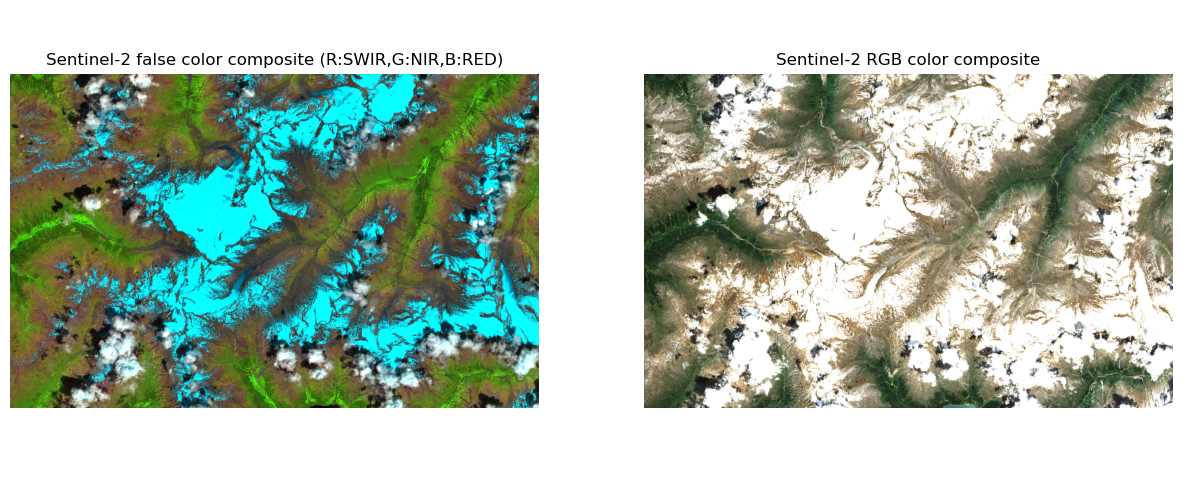

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr3/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr3/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


In [ ]:
false_color_composite = (
    (ds[["b11", "b08", "b04"]].to_dataarray(dim="bands") / 0.7)
    .clip(0, 1)
    .squeeze("time")
    .transpose("y", "x", "bands")
)
rgb_composite = (
    (ds[["b04", "b03", "b02"]].to_dataarray(dim="bands") / 0.25)
    .clip(0, 1)
    .squeeze("time")
    .transpose("y", "x", "bands")
)

fig, ax = plt.subplots(figsize=(15, 6))
ax.axis("off")
plt.subplot(121)
plt.axis("off")
plt.title("Sentinel-2 false color composite (R:SWIR,G:NIR,B:RED)")
plt.imshow(false_color_composite)
plt.subplot(122)
plt.axis("off")
plt.title("Sentinel-2 RGB color composite")
plt.imshow(rgb_composite)

(CLOUD_SNOW)=
## Cloud Masking

As usual, we mask out the clouds before proceeding in our snow mapping workflow.

In [6]:
valid_mask = np.logical_not(ds["scl"].isin([8, 9, 3]))

ds_valid = ds.where(valid_mask)

false_color_composite_masked = false_color_composite.where(valid_mask[0])

(NDSI_SNOW)=
## NDSI Computation

 ❄️ To rapidly classify snow-covered areas, we calculate the Normalized Difference Snow Index (NDSI) using the shortwave infrared (SWIR) and green bands:

$$NDSI=\frac {GREEN-SWIR}{GREEN+SWIR}$$ 

This normalized difference highlights snow by taking advantage of its high reflectance in the green band and strong absorption in the SWIR band.

In [7]:
green = ds_valid["b03"]
swir = ds_valid["b11"]

ndsi = (green - swir) / (green + swir)

snow_map = ndsi > 0.42

snow_map

<xarray.DataArray (time: 1, y: 1960, x: 3095)> Size: 6MB
dask.array<gt, shape=(1, 1960, 3095), dtype=bool, chunksize=(1, 1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2025-06-19T10:15:59.024000
    spatial_ref  int64 8B 0
  * x            (x) float64 25kB 6.218e+05 6.219e+05 ... 6.528e+05 6.528e+05
  * y            (y) float64 16kB 5.197e+06 5.197e+06 ... 5.178e+06 5.178e+06

(Snow_Map_SNOW)=
## Snow Map Visualization

Let's visualize the classification output and compare it with the cloud-masked false color composite.

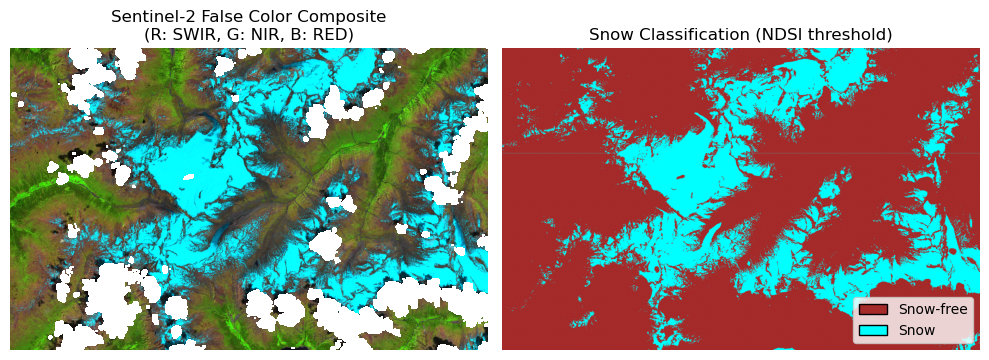

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot RGB image
axes[0].imshow(false_color_composite_masked)
axes[0].axis("off")
axes[0].set_title("Sentinel-2 False Color Composite\n(R: SWIR, G: NIR, B: RED)")

# Plot binary snow classification
binary_data = snow_map.squeeze("time")

# Define discrete colormap: 0 = no snow (light gray), 1 = snow (blue)
cmap = ListedColormap(["brown", "cyan"])

im = axes[1].imshow(binary_data, cmap=cmap)
axes[1].axis("off")
axes[1].set_title("Snow Classification (NDSI threshold)")

# Create custom legend
legend_elements = [
    Patch(facecolor="brown", edgecolor="k", label="Snow-free"),
    Patch(facecolor="cyan", edgecolor="k", label="Snow"),
]

axes[1].legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.show()

Finally, let's compare our snow map with the Scene Classification Layer (SCL) shipped with the Sentinel-2 L2A data:

In [9]:
scl_snow_ice_map = ds.scl == 11
scl_snow_ice_map

<xarray.DataArray 'scl' (time: 1, y: 1960, x: 3095)> Size: 6MB
dask.array<eq, shape=(1, 1960, 3095), dtype=bool, chunksize=(1, 1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2025-06-19T10:15:59.024000
    spatial_ref  int64 8B ...
  * x            (x) float64 25kB 6.218e+05 6.219e+05 ... 6.528e+05 6.528e+05
  * y            (y) float64 16kB 5.197e+06 5.197e+06 ... 5.178e+06 5.178e+06

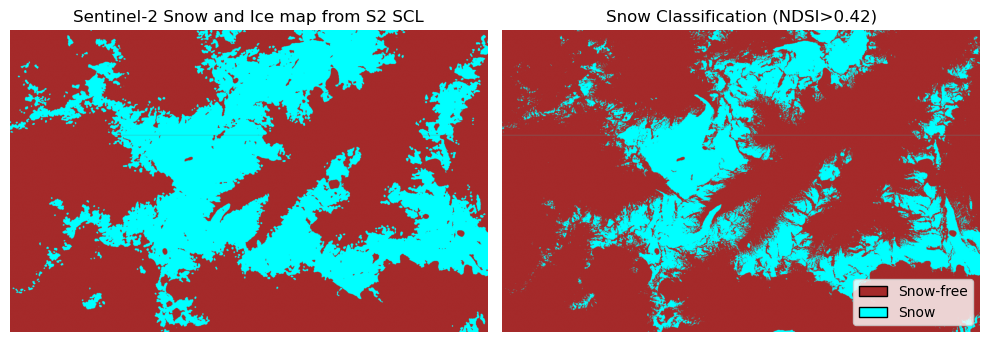

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define discrete colormap: 0 = no snow (light gray), 1 = snow (blue)
cmap = ListedColormap(["brown", "cyan"])

# Plot SCL Snow and Ice map
axes[0].imshow(scl_snow_ice_map.squeeze("time"), cmap=cmap)
axes[0].axis("off")
axes[0].set_title("Sentinel-2 Snow and Ice map from S2 SCL")

# Plot binary snow classification
binary_data = snow_map.squeeze("time")

im = axes[1].imshow(binary_data, cmap=cmap)
axes[1].axis("off")
axes[1].set_title("Snow Classification (NDSI>0.42)")

# Create custom legend
legend_elements = [
    Patch(facecolor="brown", edgecolor="k", label="Snow-free"),
    Patch(facecolor="cyan", edgecolor="k", label="Snow"),
]

axes[1].legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.show()

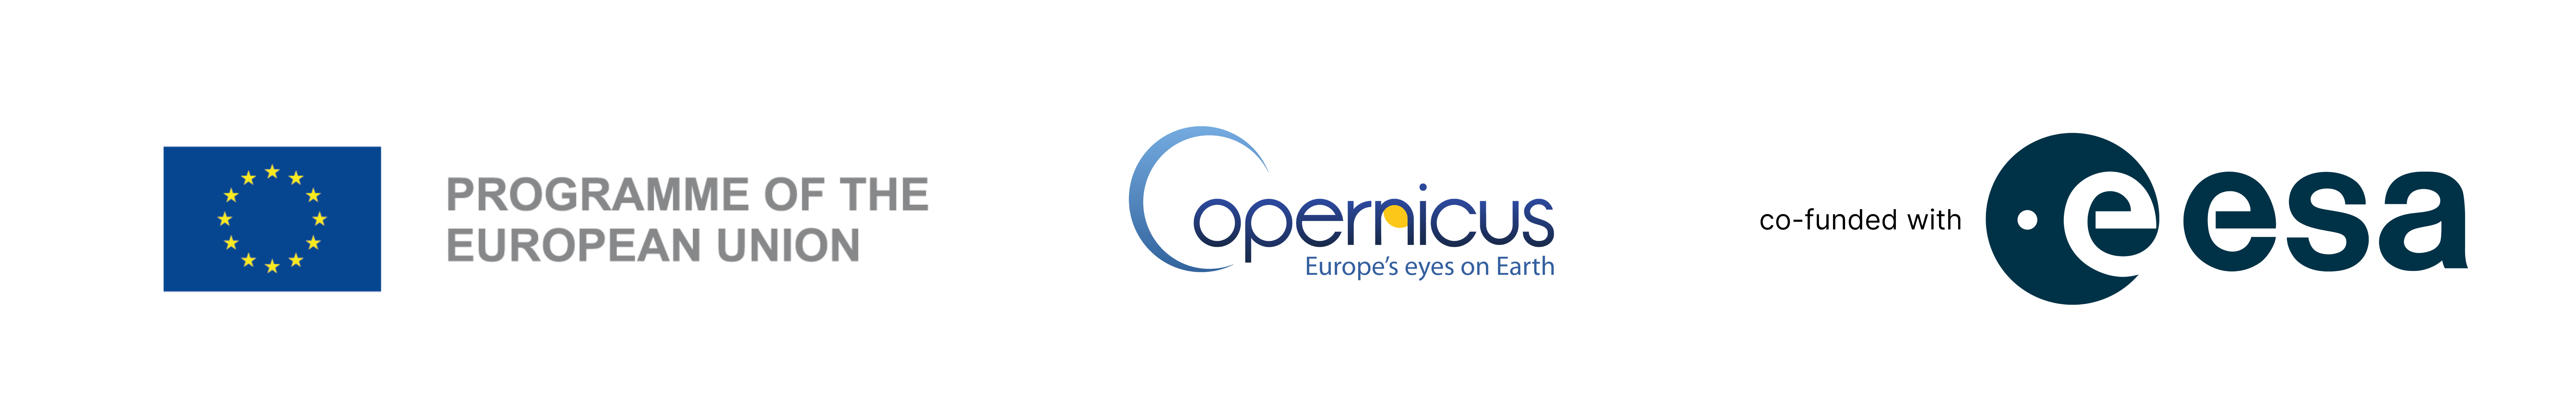